<a href="https://colab.research.google.com/github/bnsreenu/python_for_microscopists/blob/master/331_fine_tune_SAM_mito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://youtu.be/83tnWs_YBRQ

**This notebook walks you through the process of fine-tuning a Segment Anything Model (SAM) using custom data**.
<p>

**What is SAM?**
<br>
SAM is an image segmentation model developed by Meta AI. It was trained over 11 billion segmentation masks from millions of images. It is designed to take human prompts, in the form of points, bounding boxes or even a text prompt describing what should be segmented.
<p>

**What are the key features of SAM?**
<br>

* **Zero-shot generalization:** SAM can be used to segment objects that it has never seen before, without the need for additional training.

* **Flexible prompting:** SAM can be prompted with a variety of input, including points, boxes, and text descriptions.

* **Real-time mask computation:** SAM can generate masks for objects in real time. This makes SAM ideal for applications where it is necessary to segment objects quickly, such as autonomous driving and robotics.

* **Ambiguity awareness:** SAM is aware of the ambiguity of objects in images. This means that SAM can generate masks for objects even when they are partially occluded or overlapping with other objects.

<p>

**How does SAM work?**
<br>
SAM works by first encoding the image into a high-dimensional vector representation. The prompt is encoded into a separate vector representation. The two vector representations are then combined and passed to a mask decoder, which outputs a mask for the object specified by the prompt.
<p>
The image encoder is a vision transformer (ViT-H) model, which is a large language model that has been pre-trained on a massive dataset of images. The prompt encoder is a simple text encoder that converts the input prompt into a vector representation. The mask decoder is a lightweight transformer model that predicts the object mask from the image and prompt embeddings.
<p>

**SAM paper:** https://arxiv.org/pdf/2304.02643.pdf​
<p>

**Link to the dataset used in this demonstration:** https://www.epfl.ch/labs/cvlab/data/data-em/
<br>Courtesy: EPFL
<p>

This code has been heavily adapted from this notebook but modified to work with a truly custom dataset where we have a bunch of images and binary masks.
https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SAM/Fine_tune_SAM_(segment_anything)_on_a_custom_dataset.ipynb



In [ ]:
# Install the required libraries
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip install patchify

Traceback (most recent call last):
  File "/home/sivar/.vscode/extensions/ms-python.python-2025.0.0-linux-x64/python_files/python_server.py", line 133, in exec_user_input
    retval = callable_(user_input, user_globals)
  File "<string>", line 3
    !pip install git+https://github.com/facebookresearch/segment-anything.git
    ^
SyntaxError: invalid syntax



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage
import os
from PIL import Image
import numpy as np
import glob
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch

In [3]:
import glob
import numpy as np
import cv2

# Desired size: width=1024, height=1024
target_size = (1024, 1024)

# Get sorted list of image file paths
image_paths = sorted(glob.glob("data/train1/images/*"))
mask_paths  = sorted(glob.glob("data/train1/masks/*"))

# Load and resize images
images = []
for p in image_paths:
    img = cv2.imread(p, cv2.IMREAD_COLOR)
    img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR)
    images.append(img_resized)

masks = []
for p in mask_paths:
    mask = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
    mask_resized = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
    masks.append(mask_resized)

# Convert lists to numpy arrays
images_stack = np.stack(images, axis=0)
masks_stack = np.stack(masks, axis=0)

print("Images shape:", images_stack.shape)
print("Masks shape:", masks_stack.shape)


Images shape: (179, 1024, 1024, 3)
Masks shape: (179, 1024, 1024)


Load data into numpy arrays. Here we are importing a tiff stack containing 165 images of size 768x1024. You can use glob to import multiple images from a directory or any other method. The goal is to end up with a numpy array for images and an array for masks.

Now. let us divide these large images into smaller patches for training. We can use patchify or write custom code.

In [4]:
#Desired patch size for smaller images and step size.
patch_size = 256
step = 256

In [5]:

all_img_patches = []

for idx in range(images_stack.shape[0]):
    large_image = images_stack[idx]  # Color image with shape (1024, 1024, 3)
    # Define patch shape for a color image
    patch_shape = (patch_size, patch_size, large_image.shape[2])
    patches_img = patchify(large_image, patch_shape, step=step)
    
    
    # patches_img will have shape (n_patches_y, n_patches_x, patch_size, patch_size, channels)
    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, 0,:, :, :]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)


#Let us do the same for masks
all_mask_patches = []
for img in range(masks_stack.shape[0]):
    large_mask = masks_stack[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)
    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i, j, :, :]
            #print(np.unique(single_patch_mask))
            #single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)
            all_mask_patches.append(single_patch_mask)
masks = np.array(all_mask_patches)

In [6]:
images.shape

(2864, 256, 256, 3)

Now, let us delete empty masks as they may cause issues later on during training. If a batch contains empty masks then the loss function will throw an error as it may not know how to handle empty tensors.

In [7]:
# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_masks.shape)

Image shape: (2443, 256, 256, 3)
Mask shape: (2443, 256, 256)


In [26]:
print(filtered_masks[3])

[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


Let us create a 'dataset' that serves us input images and masks for the rest of our journey.

In [8]:
from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

/home/sivar/.conda/envs/mag_nal/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
len(dataset)

2440

Let us make sure out images and masks (labels) are loading appropriately

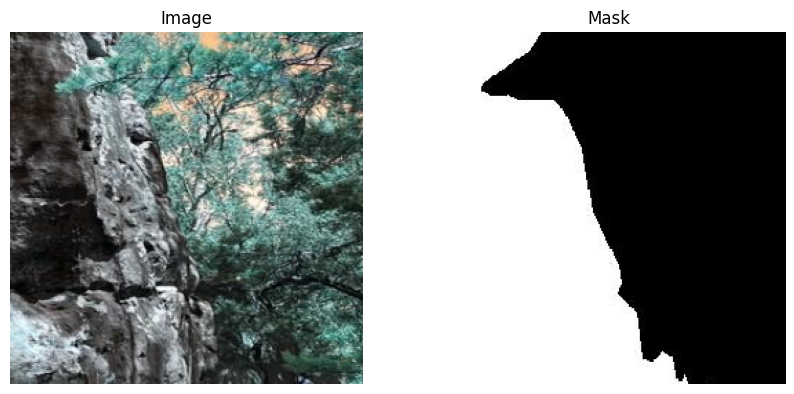

In [9]:
import random
import matplotlib.pyplot as plt

# Randomly select an index from the dataset
rand_idx = random.randint(0, len(dataset) - 1)
sample = dataset[rand_idx]
#print("Sample type:", rand_idx)
#2175
# Retrieve the image and mask from the sample
rand_image = sample["image"]  # This is a PIL image
rand_mask  = sample["label"]   # This is a PIL image (for mask)

# Create the subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))


# Display the image
axes[0].imshow(rand_image)
axes[0].set_title("Image")
axes[0].axis("off")

# Display the mask; use cmap="gray" for a grayscale image
axes[1].imshow(rand_mask, cmap="gray", vmin=0, vmax=255)
axes[1].set_title("Mask")
axes[1].axis("off")

plt.show()

Get bounding boxes from masks. You can get here directly if you are working with coco style annotations where bounding boxes are captured in a JSON file.

In [1]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [10]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [12]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [14]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [15]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)


pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


/home/sivar/.conda/envs/mag_nal/lib/python3.10/site-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)


In [16]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

In [17]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [18]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

In [19]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [20]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [21]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 1

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

  0%|          | 0/1222 [00:00<?, ?it/s]/home/sivar/.conda/envs/mag_nal/lib/python3.10/site-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)
  0%|          | 0/1222 [00:01<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.50 GiB. GPU 0 has a total capacity of 3.69 GiB of which 1.37 GiB is free. Including non-PyTorch memory, this process has 2.30 GiB memory in use. Of the allocated memory 2.12 GiB is allocated by PyTorch, and 86.29 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# Save the model's state dictionary to a file
torch.save(model.state_dict(), "/content/drive/MyDrive/ColabNotebooks/models/SAM/mito_model_checkpoint.pth")

**Inference**

In [ ]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [ ]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_mito_model.load_state_dict(torch.load("/content/drive/MyDrive/ColabNotebooks/models/SAM/mito_full_data_10_epochs_model_checkpoint.pth"))

<All keys matched successfully>

In [ ]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

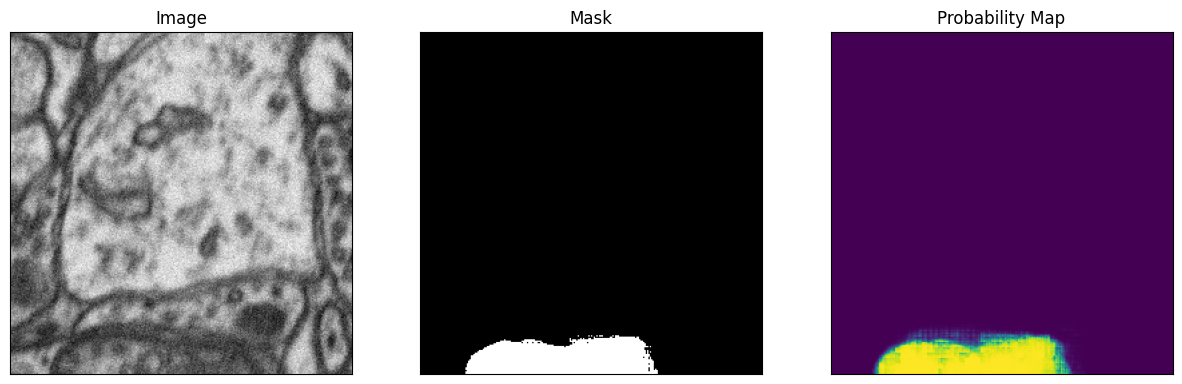

In [ ]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

# let's take a random training example
idx = random.randint(0, filtered_images.shape[0]-1)

# load image
test_image = dataset[idx]["image"]

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()


Now, let us load a new image and segment it using our trained model. NOte that we need to provide some prompt. Since we do not know where the objects are going to be we cannot supply bounding boxes. So let us provide a grid of points as our prompt.

In [ ]:
#Apply a trained model on large image
large_test_images = tifffile.imread("/content/drive/MyDrive/ColabNotebooks/data/mitochondria/small_dataset_for_training/images/12_training_mito_images.tif")
large_test_image = large_test_images[1]
patches = patchify(large_test_image, (256, 256), step=256)  #Step=256 for 256 patches means no overlap


In [ ]:
"""
input_points (torch.FloatTensor of shape (batch_size, num_points, 2)) —
Input 2D spatial points, this is used by the prompt encoder to encode the prompt.
Generally yields to much better results. The points can be obtained by passing a
list of list of list to the processor that will create corresponding torch tensors
of dimension 4. The first dimension is the image batch size, the second dimension
is the point batch size (i.e. how many segmentation masks do we want the model to
predict per input point), the third dimension is the number of points per segmentation
mask (it is possible to pass multiple points for a single mask), and the last dimension
is the x (vertical) and y (horizontal) coordinates of the point. If a different number
of points is passed either for each image, or for each mask, the processor will create
“PAD” points that will correspond to the (0, 0) coordinate, and the computation of the
embedding will be skipped for these points using the labels.

"""
# Define the size of your array
array_size = 256

# Define the size of your grid
grid_size = 10

# Generate the grid points
x = np.linspace(0, array_size-1, grid_size)
y = np.linspace(0, array_size-1, grid_size)

# Generate a grid of coordinates
xv, yv = np.meshgrid(x, y)

# Convert the numpy arrays to lists
xv_list = xv.tolist()
yv_list = yv.tolist()

# Combine the x and y coordinates into a list of list of lists
input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv_list, yv_list)]

#We need to reshape our nxn grid to the expected shape of the input_points tensor
# (batch_size, point_batch_size, num_points_per_image, 2),
# where the last dimension of 2 represents the x and y coordinates of each point.
#batch_size: The number of images you're processing at once.
#point_batch_size: The number of point sets you have for each image.
#num_points_per_image: The number of points in each set.
input_points = torch.tensor(input_points).view(1, 1, grid_size*grid_size, 2)

In [ ]:
print(np.array(input_points).shape)

(1, 1, 100, 2)


In [ ]:
patches.shape

(3, 4, 256, 256)

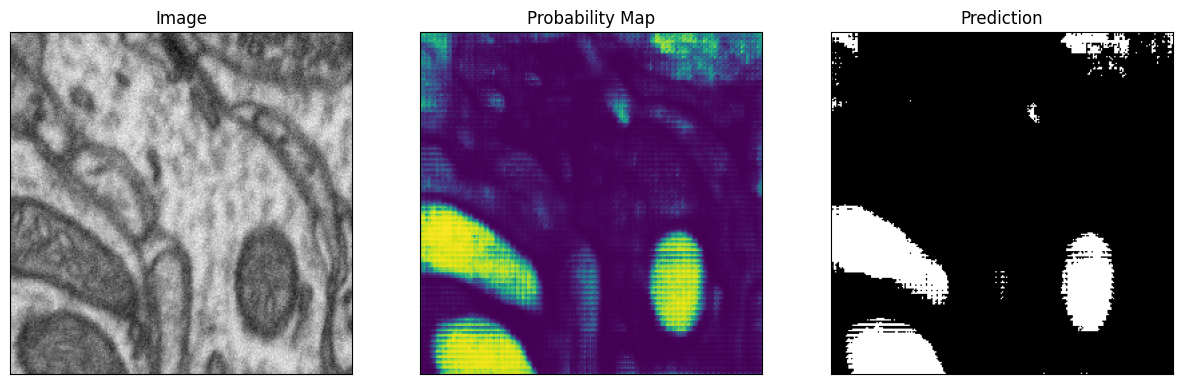

In [ ]:
# Select a random patch for segmentation

# Compute the total number of 256x256 arrays
#num_arrays = patches.shape[0] * patches.shape[1]
# Select a random index
#index = np.random.choice(num_arrays)
# Compute the indices in the original array
#i = index // patches.shape[1]
#j = index % patches.shape[1]

#Or pick a specific patch for study.
i, j = 1, 2

# Selectelected patch for segmentation
random_array = patches[i, j]


single_patch = Image.fromarray(random_array)
# prepare image for the model

#First try without providing any prompt (no bounding box or input_points)
#inputs = processor(single_patch, return_tensors="pt")
#Now try with bounding boxes. Remember to uncomment.
inputs = processor(single_patch, input_points=input_points, return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}
my_mito_model.eval()


# forward pass
with torch.no_grad():
  outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
single_patch_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
single_patch_prob = single_patch_prob.cpu().numpy().squeeze()
single_patch_prediction = (single_patch_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(single_patch), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(single_patch_prob)  # Assuming the second image is grayscale
axes[1].set_title("Probability Map")

# Plot the second image on the right
axes[2].imshow(single_patch_prediction, cmap='gray')  # Assuming the second image is grayscale
axes[2].set_title("Prediction")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()